In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
matplotlib.use("Agg")
import matplotlib.animation as animation


###Clear this laterr...

/home/matyi/miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
class petri():
    """make a function instead??"""
    def __init__(self, sector_width=10, sectorNr=5, height = 20):
        #row = np.array(np.logspace(0, concentration, num=width))
        
        #np.insert(row,0,0)
        edges = np.zeros(sector_width)
        #print (edges)
        for i in range(sectorNr):
            #print (i)
            edges  = np.append(edges, np.ones(sector_width)*10**i, 0)
        self.concentrationMap = np.tile(edges, (height,1))
        #print (edges)
    def printmap(self):

        print (self.concentrationMap)
        print (self.concentrationMap.shape)

In [71]:
class bacteria():
    
    def __init__(self,  petriDish, init_strength=0.2,):
        
        ##Base attributes
        self.dish=petriDish
        self.shape= self.dish.concentrationMap.shape
        
        self.bacteriaMap = np.zeros(self.shape)
        self.bacteriaMap[:,0] = init_strength
        
        
        ##Attributes for evolving
        self.mu=1
        self.sigma=0.08
        self.generation=0
        self.liveBacMask=np.zeros(self.shape)
        self.liveBacMask[:,0] = 1
        self.ageMap = np.zeros(self.shape)
        self.ageMap[:,0] = 1
        
        
        ##Attributes for pretty plotting
        self.norm1 = mpl.colors.LogNorm()
        self.colormap1='Blues'
        
        self.norm2 = mpl.colors.PowerNorm(gamma=1)
        self.colormap2='flag'
        
        ##Attributes for video making
        self.resistanceVideo=[]
        self.fig1=plt.figure()
        self.ax1 = self.fig1.add_subplot(1, 1, 1)
        
        self.ageVideo=[]
        self.fig2=plt.figure()
        self.ax2 = self.fig2.add_subplot(1, 1, 1)      
        
        Writer = animation.writers['ffmpeg']
        self.writer = Writer(fps=20, metadata=dict(artist='MatyasCzeman'), bitrate=3600)
        
        
        
    def showBacMap(self, cmap='nipy_spectral', pretty=False ):      

        if pretty:
            prettyMap=np.zeros_like(self.bacteriaMap)
            uniqVals=np.unique(np.sort(self.bacteriaMap.flatten()))
            for index, value in np.ndenumerate(self.bacteriaMap):
                prettyMap[index] = np.where(uniqVals==value)[0]
                
            plt.pcolormesh(prettyMap, cmap=cmap, norm=mpl.colors.LogNorm())
        else:
            plt.pcolormesh(self.bacteriaMap, cmap=self.colormap1, norm=self.norm1)
        
    def showAgeMap(self, cmap='nipy_spectral',  pretty=False):
        
        if pretty:
            prettyMap=np.zeros_like(self.ageMap)
            uniqVals=np.unique(np.sort(self.ageMap.flatten()))
            for index, value in np.ndenumerate(self.ageMap):
                prettyMap[index] = np.where(uniqVals==value)[0]
                
            plt.pcolormesh(prettyMap, cmap=cmap, norm=mpl.colors.LogNorm())
            
        else:
            plt.pcolormesh(self.ageMap, cmap=self.colormap2, norm=self.norm2)     
        
    def spread (self):
        
        newMap = np.empty_like (self.bacteriaMap)
        newMap[:] = self.bacteriaMap
        for (x,y), element in np.ndenumerate(self.bacteriaMap):
            #print (x,y, element)
            if np.random.rand() > 0.55 and self.bacteriaMap[x,y] == 0 : #and self.bacteriaMap[x,y] > self.dish.concentrationMap[x,y]:
            # if square is not empty and resistance > concentration:
                try: 
                    if self.bacteriaMap[x-1,y] > self.dish.concentrationMap[x,y]:
                        newMap[x,y] = self.bacteriaMap[x-1,y]
                except: pass
                try: 
                    if self.bacteriaMap[x+1,y] > self.dish.concentrationMap[x,y]:
                        newMap[x,y] = self.bacteriaMap[x+1,y]
                except: pass
                try: 
                    if self.bacteriaMap[x,y+1] > self.dish.concentrationMap[x,y]:
                        pass
                        newMap[x,y] = self.bacteriaMap[x,y+1]
                except: pass
                try: 
                    if self.bacteriaMap[x,y-1] > self.dish.concentrationMap[x,y]:
                        newMap[x,y] = self.bacteriaMap[x,y-1]
                except: pass
                # I use try to eliminate index out of range errors at the edges
                
        self.bacteriaMap = newMap 
        self.checkStats()
        ageMap = self.age()
        
        self.ageVideo.append((self.ax2.pcolormesh(ageMap,
                                         cmap='Blues'),))
                   
        ##Save current status for saving it as a video later
        self.resistanceVideo.append((self.ax1.pcolormesh(self.bacteriaMap,
                                         cmap=self.colormap1, norm=self.norm1),))
        
     
    def checkStats(self):
        """Counts new values for visualizaton after every spread() step"""
        newMap = np.empty_like (self.bacteriaMap)
        newMap[:] = self.bacteriaMap
        newMap[np.where(newMap == 0)] = np.nan
             
        
        maxval=np.nanmax(newMap)
        minval=np.nanmin(newMap)
        self.norm1 = mpl.colors.LogNorm(vmax=maxval, vmin=minval)
        #self.mean = np.nanmean(newMap)

    def evolve(self):
        
        # mean and standard deviation
        mutationMap = np.random.normal(self.mu, self.sigma, self.shape)
        #plt.pcolor(mutationMap)
        #print("after")
        mutationMap[self.liveBacMask==0]=1
        #plt.pcolor(mutationMap)
        self.bacteriaMap = self.bacteriaMap * mutationMap
        self.generation+=1
        
        
    def age(self):
        
        #newMap  = np.empty_like (self.ageMap)
        #newMap[:] = self.ageMap
        for (x,y), element in np.ndenumerate(self.ageMap):
            if  self.bacteriaMap[x,y] != 0:
                self.ageMap[x,y] += 1
                
        deathMask=np.zeros(self.shape)
        deathMask[self.ageMap>0]   = 1   # at occupied square bacs should evolve
        deathMask[self.ageMap>400] = 0   # at old square bacs sould not evolve
        
        ### 1 where there's a living bacteria
        self.liveBacMask=deathMask
        
        return self.ageMap
        
    def onlineSpreading(self, steps=100):
        
        figOnline,ax = plt.subplots()
        for f in range(steps):
            self.evolve()
            self.spread()
            ax.pcolormesh(self.bacteriaMap, cmap=self.colormap1, norm=self.norm1)
            figOnline.canvas.draw()
            time.sleep(0.1)
            
    def saveVideo(self):

        dpi = 80
        width = 16
        height = 9 ## res = dpi*width*height
        self.fig1.set_size_inches(width, height, True)
        
        
        self.fig2.set_size_inches(width, height, True)
        
        #resVid = animation.ArtistAnimation(self.fig1, self.resistanceVideo, interval=500, repeat_delay=3000,
        #                           blit=True)
        #resVid.save('simul_resist%d.mp4' %self.generation, writer=self.writer, dpi=dpi)

        ageVid = animation.ArtistAnimation(self.fig2, self.ageVideo, interval=500, repeat_delay=3000,
                                   blit=True)
        ageVid.save('simul_ages%d.mp4' %self.generation, writer=self.writer, dpi=dpi)

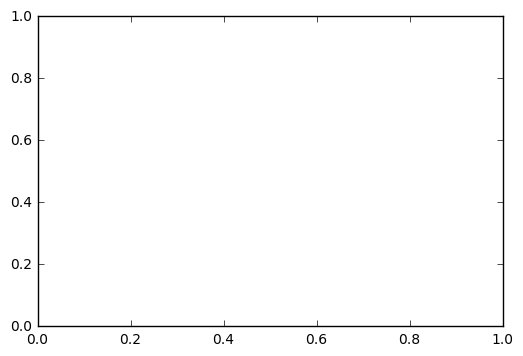

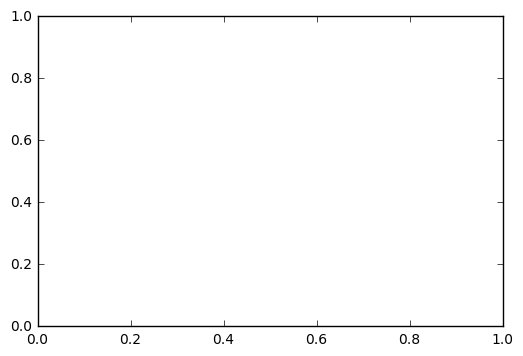

In [72]:
petriD = petri(10,4,30)
eColi=bacteria(petriD, 0.2)

In [73]:
# while True:
simulStep=200

for i in range(simulStep):
   
    eColi.evolve()
    
    eColi.spread()
    

print ("Finished")


Finished


In [27]:
ORIG=eColi.ageMap
RESULT=np.zeros_like(ORIG)
UNIQ=np.unique(np.sort(ORIG.flatten()))

In [28]:
for index, value in np.ndenumerate(ORIG):
    RESULT[index] = np.where(UNIQ==value)[0]

In [34]:
print (np.max(RESULT), np.min(RESULT))
minv=np.min(RESULT)
maxv=np.max(RESULT)

186.0 0.0


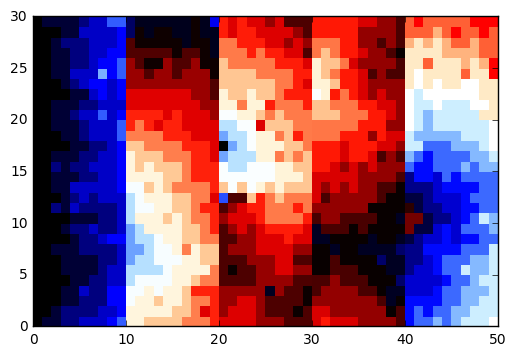

In [29]:
plt.pcolormesh(eColi.ageMap, cmap='flag')

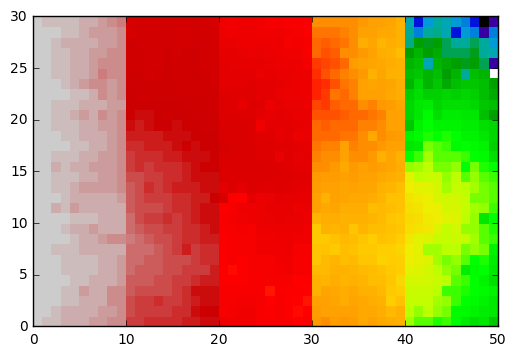

In [47]:
plt.pcolormesh(RESULT, cmap='nipy_spectral',norm=mpl.colors.LogNorm())

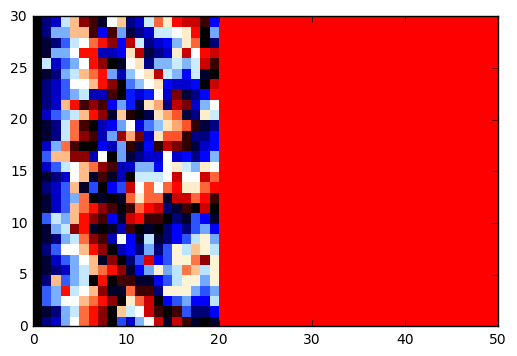

In [68]:
# LogNorm Normalize() PowerNorm(gamma=1./2.) 
## gamma ~.2 end is ok
## gamma ~1 middle is ok
eColi.showAgeMap(pretty=False)
#best cmap for this : flag, prism
#'prism' 'rainbow' 'gnuplot' 'jet' 'nipy_spectral' 'flag' 'prism' 'Paired'


In [48]:
eColi.saveVideo()


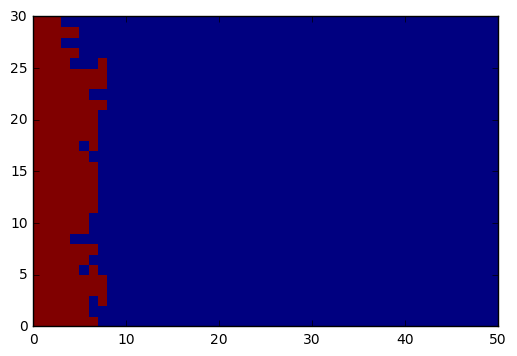

In [13]:
plt.pcolor(eColi.liveBacMask)

<IPython.core.display.Javascript object>


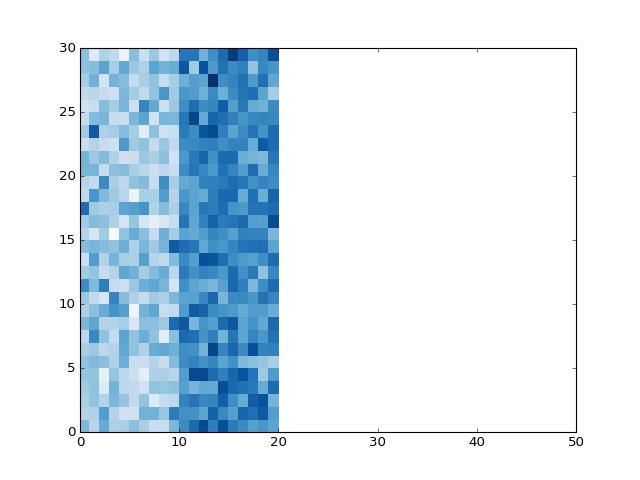

Finished


In [17]:
%matplotlib notebook
eColi.onlineSpreading(steps=20)
print ("Finished")


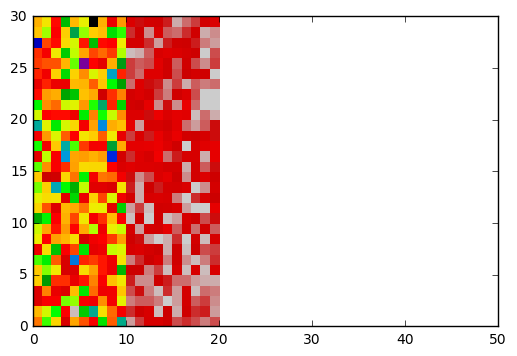

In [74]:
%matplotlib inline
eColi.showBacMap(pretty=True)